# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)
import math
import scipy.stats as sct

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer, TfidfTransformer
)

In [33]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [34]:
df = pd.read_csv("countries.csv")

In [35]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

df.columns = new_column_names

df.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [36]:
df.describe().round(2)

,Population,Area,GDP
count,2.270000e+02,227.00,226.00
mean,2.874028e+07,598226.96,9689.82
std,1.178913e+08,1790282.24,10049.14
min,7.026000e+03,2.00,500.00
25%,4.376240e+05,4647.50,1900.00
50%,4.786994e+06,86600.00,5550.00
75%,1.749777e+07,441811.00,15700.00
max,1.313974e+09,17075200.00,55100.00


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country           227 non-null    object 
 1   Region            227 non-null    object 
 2   Population        227 non-null    int64  
 3   Area              227 non-null    int64  
 4   Pop_density       227 non-null    object 
 5   Coastline_ratio   227 non-null    object 
 6   Net_migration     224 non-null    object 
 7   Infant_mortality  224 non-null    object 
 8   GDP               226 non-null    float64
 9   Literacy          209 non-null    object 
 10  Phones_per_1000   223 non-null    object 
 11  Arable            225 non-null    object 
 12  Crops             225 non-null    object 
 13  Other             225 non-null    object 
 14  Climate           205 non-null    object 
 15  Birthrate         224 non-null    object 
 16  Deathrate         223 non-null    object 
 1

In [38]:
# transformando as "string" em float 
def parse_str_float(str):
    try:
        return float(str.replace(",", "."))
    except:
        return str

df = df.applymap(parse_str_float)

In [39]:
exploracao = pd.DataFrame({'colunas' : df.columns,
                   'tipos' : df.dtypes,
                   'missing' : df.isna().sum()})
exploracao

,colunas,tipos,missing
Country,Country,object,0
Region,Region,object,0
Population,Population,int64,0
Area,Area,int64,0
Pop_density,Pop_density,float64,0
Coastline_ratio,Coastline_ratio,float64,0
Net_migration,Net_migration,float64,3
Infant_mortality,Infant_mortality,float64,3
GDP,GDP,float64,1
Literacy,Literacy,float64,18


In [41]:
# para questao 6 e 7
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [43]:
def q1():
    lista_regioes = list(df.Region.unique())
    lista_regioes_formatadas = list(map(lambda regiao: regiao.strip(), lista_regioes))
    lista_regioes_formatadas.sort(reverse=False)
    
    return lista_regioes_formatadas

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [44]:
def q2():
    discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    discretizer.fit(df[["Pop_density"]])

    pop_density_bins = discretizer.transform(df[["Pop_density"]])
    
    posicao_90 = math.trunc((90 / 100) * len(pop_density_bins))
    
    return len(pop_density_bins) - posicao_90

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [ ]:
def q3():
    one_hot_encoder_region = OneHotEncoder(sparse=False, dtype=np.int)

    one_hot_encoder_region.fit(df[["Region"]])

    region_encoded = one_hot_encoder_region.transform(df[["Region"]])

    region_encoded = one_hot_encoder_region.fit_transform(df[["Region"]])

    n_atributos_region = region_encoded.shape[1]

    df.Climate = df.Climate.fillna(-1.0)

    one_hot_encoder_climate = OneHotEncoder(sparse=False, dtype=np.int)

    one_hot_encoder_climate.fit(df[["Climate"]])

    climate_encoded = one_hot_encoder_climate.transform(df[["Climate"]])

    climate_encoded = one_hot_encoder_climate.fit_transform(df[["Climate"]])

    n_atributos_climate = climate_encoded.shape[1]

    return n_atributos_region + n_atributos_climate

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [51]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [62]:
def q4():
    num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("standard_scaler", StandardScaler())
    ])
    
    pipeline_transformation = num_pipeline.fit(df[new_column_names[2:]])
    
    df_test_country = pd.DataFrame([test_country], columns = df.columns)
    
    pipeline_test = num_pipeline.transform(df_test_country[new_column_names[2:]])
    
    df_result = pd.DataFrame(pipeline_test, columns=new_column_names[2:])
    
    return float(df_result.Arable.round(3))

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

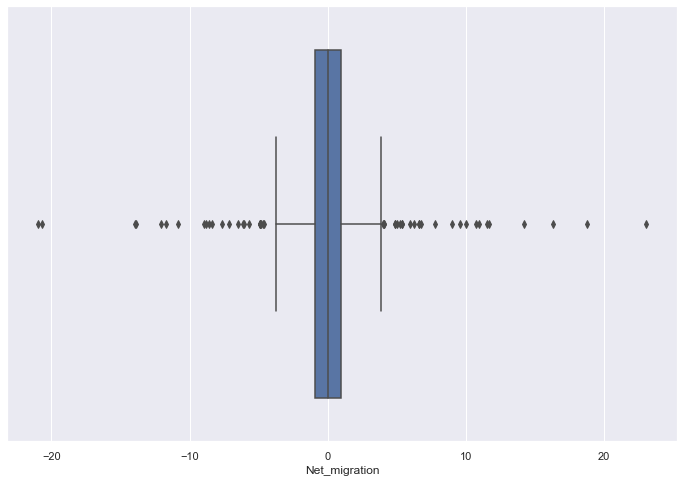

In [47]:
sns.boxplot(x=df.Net_migration)

In [48]:
def q5():
    q25 = df.Net_migration.quantile(.25)
    q75 = df.Net_migration.quantile(.75)
    IQR = q75 - q25

    limite_sup = q75 + 1.5 * IQR
    limite_inf = q25 - 1.5 * IQR

    sum_limite_superior = df[df.Net_migration > limite_sup].shape[0]
    sum_limite_inferior = df[df.Net_migration < limite_inf].shape[0]
    
    return tuple((sum_limite_inferior, sum_limite_superior, False))

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [49]:
def q6(): 
    count_vectorizer = CountVectorizer()
    newsgroup_counts = count_vectorizer.fit_transform(newsgroup.data)
    
    return int(sum(newsgroup_counts[:,count_vectorizer.vocabulary_.get("phone")].toarray())[0])

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [50]:
def q7():
    tfidf_vectorizer = TfidfVectorizer()
    newsgroup_tfidf = tfidf_vectorizer.fit_transform(newsgroup.data)
    phone = sum(newsgroup_tfidf[:,tfidf_vectorizer.vocabulary_.get("phone")].toarray())[0]
    
    return float(np.round(phone,3))